## Visibility Script Prototype
### This Jupyter Notebook is a prototype for the visibility script to see if targets are visible in La Palma 
#### It follows this plan:
- User enters a date and the script will calculate all the values within the time-frame of 12pm of the chosen date to 12pm of the next day (UTC time). 
    - As the time in La Palma where the Liverpool Telescope is based is +1/+0h UT it is guaranteed that the dark time will be between these two times.
- Using this time scale the time when darktime starts and ends will be calculated for the night.
- Next for a given target the time it transits the meridian and the altitude at which it does it will be calculated.
    - If the transit altitude is below 35 degrees for La Palma then the target is discarded.
    - If the transit altitude is above 35 degrees we cab go to the next step.
- Now the HA at which the star is at 35 degrees is calculated.
    - The transit time minus the hour angle is the time at which the target is rising at 35 degs
    - The transit time plus the hour angle is the time the target is setting at 35 degs. 
- If either of the above cross over with the dark time interval then they will have some observable time from La Palma. The flow chart below shows all the possibilities that a target could have visibility-wise. 
![flow_chart](../../Lab-book/Extras/vis-script-plan.png)

In [1]:
## IMPORTS ###
import datetime as dt
from skyfield import almanac
from skyfield.api import N, E, wgs84, load, utc, Star
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import csv
import json

In [2]:
### Define constants ##
# Location is La Palma
lat = 28.6468866 
long = -17.7742491 
elv = 2326.0
loc_name = "La Palma"
# Target (Aldebaran)
name = "Aldebaran"
RA = (4+(35/60)+(55.23907/3600))*15 #in decimal degrees to match TNS (04h 35m 55.23907s)
Dec = 16+(30/60)+(33.4885/3600) #in decimal degrees to match TNS (+16° 30′ 33.4885″)
# Date 
file_date = "20221010" #to match the date of the update (which is the day before the one we are interested in)

In [3]:
# get the date intrested in (today) and the next day at 12pm and add UTC time zone
today = dt.datetime.strptime(file_date, '%Y%m%d') + dt.timedelta(days=1.5)
today =today.replace(tzinfo=utc)
tomorrow = today + dt.timedelta(days=1)
tomorrow = tomorrow.replace(tzinfo=utc)

print(f'Today is: {today.strftime("%d/%m/%Y, %H:%M:%S")}')
print(f'Tomorrow is: {tomorrow.strftime("%d/%m/%Y, %H:%M:%S")}')

Today is: 11/10/2022, 12:00:00
Tomorrow is: 12/10/2022, 12:00:00


In [4]:
## set up skyfield observing ##
location = wgs84.latlon(lat * N, long * E, elevation_m = elv) #location of la palma
ts = load.timescale() #loads in timescale
eph = load('de421.bsp')  #loads in ephemerides

#load in objects from ephms
earth, sun, moon = eph['earth'], eph['sun'], eph['moon']
Epos = earth + location #sets up observing position (i.e., the postion of the follow-up telescope)

#makes time objects from today and tomorrow
t0 = ts.from_datetime(today)
t1 = ts.from_datetime(tomorrow)

In [5]:
### Find the dark time start and end ### 
f = almanac.dark_twilight_day(eph, location)
times, events = almanac.find_discrete(t0, t1, f)

sunset = times[0]
darkstart = times[3]
darkend = times[4]
sunrise = times[7] #using the indcies to extract the different times of night

print(f'Sunset at {sunset.utc_strftime("%H:%M:%S %d/%m/%Y")}')
print(f'Dark time starts at {darkstart.utc_strftime("%H:%M:%S %d/%m/%Y")}')
print(f'Dark time ends at {darkend.utc_strftime("%H:%M:%S %d/%m/%Y")}')
print(f'Sunrise at {sunrise.utc_strftime("%H:%M:%S %d/%m/%Y")}')

Sunset at 18:45:42 11/10/2022
Dark time starts at 20:04:06 11/10/2022
Dark time ends at 05:51:37 12/10/2022
Sunrise at 07:10:07 12/10/2022


In [6]:
## calculate moon's alt, phase, and illumination ##
midnight = t0 + dt.timedelta(hours=12)
mastro = Epos.at(midnight).observe(moon)
mapp = mastro.apparent()
malt, maz, mdst = mapp.altaz()
mphase = almanac.moon_phase(eph, t0)
mill = almanac.fraction_illuminated(eph,"moon",midnight)
malt, mphase = malt.degrees, mphase.degrees

print(f'''At {midnight.utc_strftime("%H:%M:%S %d/%m/%Y")} the lunar altitude is {round(malt,4)} degs, 
the phase is {round(mphase,4)} degs, and the illumination is {round(mill,4)}%.''')

At 00:00:00 12/10/2022 the lunar altitude is 51.2227 degs, 
the phase is 200.0106 degs, and the illumination is 0.9495%.


In [7]:
## Need the RA of the Sun on this night
barycentric = earth.at(midnight)
astrometric = barycentric.observe(sun)
apparent = astrometric.apparent()
Sunra, Sundec, Sundistance = apparent.radec() #get the RA of the Sun
RA_Sun = Sunra.hours

print(f'The RA of the sun is {RA_Sun} hrs on {midnight.utc_strftime("%H:%M:%S %d/%m/%Y")}.')

The RA of the sun is 13.127327758223828 hrs on 00:00:00 12/10/2022.


In [8]:
## Make star object to observe in skyfield ##

#convert RA in decimal degrees to RA in hrs, mins, secs
raH = RA/15 #RA decimal degrees to decimal hours
ra_hours = int(raH) #hours of RA
raM = (raH-ra_hours)*60 #decimal mintues of RA
ra_mins = int(raM) #mintues of RA
ra_secs = (raM-ra_mins)*60 #seconds of RA

#convert DEC in decimal degrees to dec in degs, arcmins, arcsecs
dec_degs = int(Dec) #degs of dec
decM = (Dec-dec_degs)*60 #decimal arcmintues of dec
dec_mins = int(decM) #arcmintues of dec
dec_secs = (decM-dec_mins)*60 #arcseconds of dec

#make the object
target= Star(ra_hours=(ra_hours,ra_mins,ra_secs),dec_degrees=(dec_degs,dec_mins,dec_secs))

print(f"Target: {target}")

Target: Star(ra=68.98016279166667, dec=16.50930236111111, epoch=2451545.0)


In [9]:
## Function to find the time and altitude of transit ##
def transit_time(tar,t_start,t_end):
    """
    Function that finds the transit time (in UTC) of a target between two times (need to be 24hrs apart)
    and the altitude of this transit in degrees.
    Arguments:
        - tar: the target as a skyfield Star object.
        - t0: start time as a skyfield time object.
        - t1: end time (should be ~24hrs later) as a skyfield time object.
    Output:
        t_time: time that the object transits in UTC as a skyfield time object.
        t_alt: altitude in degrees that the object transits (float).
    """
    #function that calculates transit 
    f = almanac.meridian_transits(eph, tar, location)
    t, y = almanac.find_discrete(t_start, t_end, f) 
    #t is times of transit, 
    #y is array with 0 for antimerdian transit and 1 for meridian transit (which we are intrested in)
    
    #so t_time is the element at the same index as 1 in y in the t array
    meridian_index = np.where(y==1)[0]
    t_time = t[meridian_index]
    
    #now need to find altitude of star at this time
    astro = Epos.at(t_time).observe(tar)
    app = astro.apparent()
    alt, az, distance = app.altaz()
    t_alt = alt.degrees

    return t_time[0], t_alt[0]

In [10]:
t_time, t_alt = transit_time(target,t0,t1)
print(f'''The target transits the meridian at {t_time.utc_strftime("%Y-%m-%d %H:%M")}, 
with an altitude of {round(t_alt,4)} degs.''')

The target transits the meridian at 2022-10-12 04:25, 
with an altitude of 77.9098 degs.


In [11]:
## Function to find the HA at 35 deg altitude ##
def alt2HA(alt,lt,dec):
    '''
    Function that calculates the absolute value of the hour angle of a target for at a specified altitude, 
    given the latitude of the location and the declination of the target.
    Arguments:
        - alt: the altitude you want to find the value of the HA at, in decimal degrees (float).
        - lt: the latitude of the location you are observing the target, in decimal degrees (float).
        - dec: the declination of the target, in decimal degrees (float)
    Output:
        - HA: the absolute value of the HA of the target at the specified altitude in decimal hours (float).
    '''
    
    #convert dec, lat and alt into radian
    altR = np.radians(alt)
    latR = np.radians(lt)
    decR = np.radians(dec)
    
    #find the hour angle of the 
    cosHAnum = np.sin(altR) - (np.sin(latR)*np.sin(decR)) #numerator of cos(HA)
    cosHAden = np.cos(latR)*np.cos(decR) #denominator of cos(HA)
    cosHA = cosHAnum/cosHAden 
    
    #find the hour angle using arccos
    HAdeg = np.degrees(np.arccos(cosHA)) #hour angle in degrees
    HA = HAdeg/15 #hour angle in hours
    
    return HA

In [12]:
HA = alt2HA(35,lat,Dec)
print(f'The hour angle of the star at 35 degs altitude is: {round(HA,4)} hrs.')

The hour angle of the star at 35 degs altitude is: 3.9122 hrs.


In [13]:
## Find the time target rises above 35 and then sets below 35 using the HA and transit time ##
rise35 = t_time - dt.timedelta(hours=HA)
set35 = t_time + dt.timedelta(hours=HA)
print(f'Target rises above 35 degs altitude at {rise35.utc_strftime("%Y-%m-%d %H:%M")}')
print(f'Target sets below 35 degs altitude at {set35.utc_strftime("%Y-%m-%d %H:%M")}')
above35 = ((set35.utc_datetime()-rise35.utc_datetime()).seconds)/3600
print(f'The target is above 35 degs altitude for {round(above35,4)} hrs')

Target rises above 35 degs altitude at 2022-10-12 00:31
Target sets below 35 degs altitude at 2022-10-12 08:20
The target is above 35 degs altitude for 7.8242 hrs


In [14]:
## Compare the above time with the times dark time starts and ends to find observable time ##
def obs_time(dt_start,dt_end,rise_t,set_t):
    """
    Function that calculates how long a target is visible given the times dark time starts and ends, and 
    the times the target rises above and sets below a certain altitude. Note all times need to be in
    the same timezone, idealy UTC.
    Arguments:
        - dt_start: the time dark time starts as a skyfield time object.
        - dt_end: the time dark time ends as a skyfield time object.
        - rise_t: the time the target rises above the certain altitude.
        - set_t: the time the target sets below the certain altitude.
    Output:
        t_obs: the time the target is obserable in dark time, as a decimal hour (float).
    """
    
    #convert the times into datetime objects
    dt_start, dt_end = dt_start.utc_datetime(), dt_end.utc_datetime()
    rise_t, set_t = rise_t.utc_datetime(), set_t.utc_datetime()
    
    ## Now need to carry out the flow chart described above ##
    #first check is rise_t greater than dt_start
    if rise_t > dt_start:
        #if true then target rises after dark time starts
        #next check: is rise_t greater than dt_end
        if rise_t > dt_end:
            #if true target rises and sets after dark time, so cant observe
            t_obs = 0
        else:
            #if false the target rises in dark time
            #next check: is set_t greater than dt_end
            if set_t > dt_end:
                #if true then target rises in dark time and then sets after
                #so observable time is end of dark time minus rise time
                t_obs = (dt_end - rise_t).seconds/3600 #have to divide by 3600 to get in hours 
            else:
                #if false then target rises and sets in dark time
                #so observable time is just the time it is above the certain altitude
                t_obs = (set_t - rise_t).seconds/3600       
    else:
        #if false target rises before dark time
        #next check: is set_t greater than dt_start
        if set_t > dt_start:
            #if true then the target sets in dark time
            #next check: is set_t greater than dt_end
            if set_t > dt_end:
                #if true then target rises before dark time and sets after it
                #so observable time is the length of dark time
                t_obs = (dt_end - dt_start).seconds/3600
            else:
                #if false then target rises before dark time and sets in dark time
                #so observable time is the set time minus the start of dark time
                t_obs = (set_t - dt_start).seconds/3600
        else:
            #if false then target rises and sets before dark time starts, so cant observe
            t_obs = 0      
    
    return t_obs

In [15]:
t_obs = obs_time(darkstart,darkend,rise35,set35)
print(f'Target is observable above 35 degs altitude in dark time for {round(t_obs,4)} hours.')

Target is observable above 35 degs altitude in dark time for 5.3492 hours.


In [16]:
## Plot this to check ## 
# make an array of targts altitude at every 5 mins hour of night time

Time = sunset

altitudes = []
times = []

while Time.utc_datetime() < sunrise.utc_datetime():
    astro = Epos.at(Time).observe(target)
    app = astro.apparent()
    #observers star at time from position

    alt, az, distance = app.altaz()
    
    altitudes.append(alt.degrees)
    times.append(Time.utc_datetime())
    
    Time += dt.timedelta(hours=0.1)

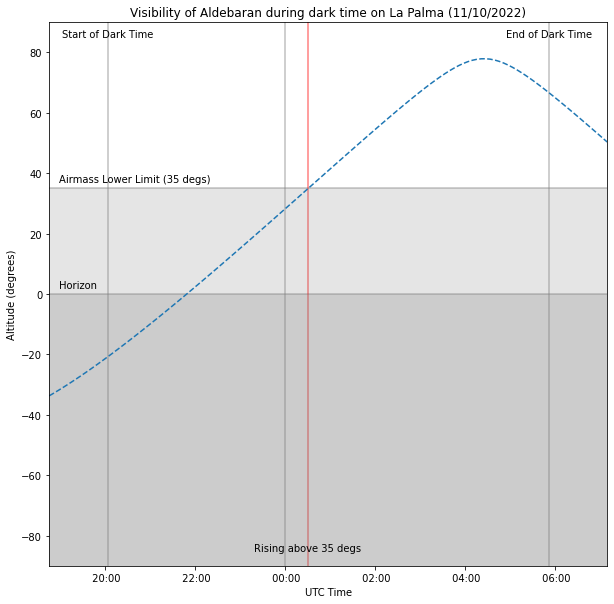

In [17]:
#then lets plot the changing altitude of target during darktime
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(times,altitudes,"--",label=name)

ax.plot(times,np.zeros(len(times)),color="grey",alpha=0.5,zorder=0) #horizon
ax.plot(times,35*np.ones(len(times)),color="grey",alpha=0.5,zorder=0) #lower alt limit

ax.vlines(darkstart.utc_datetime(), -90,90,color="grey",alpha=0.5,zorder=0) #start of darktime
ax.vlines(darkend.utc_datetime(), -90,90,color="grey",alpha=0.5,zorder=0) #end of darktime
ax.vlines(midnight.utc_datetime(), -90,90,color="grey",alpha=0.5,zorder=0)
ax.vlines(rise35.utc_datetime(), -90,90,color="r",alpha=0.5,zorder=0) #first time at 35degs
ax.vlines(set35.utc_datetime(), -90,90,color="r",alpha=0.5,zorder=0) #second time at 35degs

#annotations
ax.annotate("Start of Dark Time", (darkstart.utc_datetime(),85),ha='center')
ax.annotate("End of Dark Time", (darkend.utc_datetime(),85),ha='center')
ax.annotate("Midnight", (dt.datetime(2022, 10, 5, 0,0,0,tzinfo=utc),85),ha='center')
ax.annotate("Horizon", (sunset.utc_datetime(),2),(10,0),textcoords="offset pixels")
ax.annotate("Airmass Lower Limit (35 degs)", (sunset.utc_datetime(),37),(10,0),textcoords="offset pixels")
ax.annotate("Rising above 35 degs", (rise35.utc_datetime(),-85),ha='center')
ax.annotate("Setting below 35 degs", (set35.utc_datetime(),-85),ha='center')

#backgrounds
ax.axhspan(35, 0, facecolor='grey', alpha=0.2)
ax.axhspan(0, -90, facecolor='grey', alpha=0.4)

#formatting the plot
xfmt = mdates.DateFormatter(' %H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel("UTC Time")
ax.set_ylabel("Altitude (degrees)")
ax.set_xlim([times[0],times[-1]])
ax.set_ylim(-90,90)
ax.set_title(f'Visibility of {name} during dark time on {loc_name} ({today.strftime("%d/%m/%Y")})')

#display
plt.show()

In [20]:
# angluar separtion between moon and target during the night ##

#find the UTC time at the middle of the night
middark = ts.from_datetime(darkstart.utc_datetime()+((darkend.utc_datetime() - darkstart.utc_datetime())/2))

#loop through each time and add angular separation to list to find average
times = [darkstart,middark,darkend]
a_seps = []
for i in times:
    # angular separation doesn't depend on location on earth just time
    e = earth.at(i) #set earth as centre
    m = e.observe(moon) #observe moon at time i
    T = e.observe(target) #observe target at same time 
    asep = m.separation_from(T).degrees #find angular separation in degrees
    a_seps.append(asep) #append to list
    print(f'Angle between moon and target at {i.utc_strftime("%Y-%m-%d %H:%M")} : {round(asep,4)} degs')
    
print(f'Average angluar separtion between target and moon during night is: {round(np.mean(a_seps),4)} degs')

Angle between moon and target at 2022-10-11 20:04 : 28.0666 degs
Angle between moon and target at 2022-10-12 00:58 : 25.5521 degs
Angle between moon and target at 2022-10-12 05:52 : 23.0754 degs
Average angluar separtion between target and moon during night is: 25.5647 degs
